In [1]:
!nvidia-smi

Thu Nov  7 02:29:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  CUDA GPU                       On  | 00000000:86:00.0 Off |                  Off |
| N/A   34C    P0              23W / 250W |     48MiB / 32768MiB |     N/A      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# 기본 라이브러리 설치
# !pip install torch torchvision torchaudio
# !pip install numpy matplotlib Pillow scipy tqdm

# 데이터셋 다운로드를 위한 gdown 설치
# !pip install gdown

In [3]:
# !pip install --upgrade pip

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
from tqdm import tqdm
import gdown
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast

In [5]:
# GPU 설정
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

device = torch.device(device)

Using device: cuda


In [6]:
# AMP 설정
use_amp = device.type == 'cuda'
print(f"Using Automatic Mixed Precision: {use_amp}")

Using Automatic Mixed Precision: True


In [7]:
# 배치 사이즈 설정
batch_size = 16 if device.type == 'cuda' else 8 if device.type == 'mps' else 4
num_workers = 4 if device.type == 'cuda' else 0
pin_memory = device.type == 'cuda'

In [8]:
# 데이터셋 다운로드 함수
def download_dataset():
    data_dir = './instance-level_human_parsing'
    zip_path = 'instance-level_human_parsing.zip'

    if os.path.exists(data_dir):
        print("Dataset already exists. Skipping download.")
        return True

    print("Downloading dataset...")
    try:
        url = 'https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz'
        gdown.download(url, zip_path, quiet=False)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')

        os.remove(zip_path)
        return True
    except Exception as e:
        print(f"Error during download/extraction: {e}")
        if os.path.exists(zip_path):
            os.remove(zip_path)
        return False

In [9]:
# 데이터셋 클래스
class CIHPDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))
            
        return image, mask

In [10]:
# ASPP 모듈
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, output_stride=16):
        super(ASPP, self).__init__()
        
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
            
        self.aspp1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.aspp2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=dilations[1],
                     dilation=dilations[1], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.aspp3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=dilations[2],
                     dilation=dilations[2], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.aspp4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=dilations[3],
                     dilation=dilations[3], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.project(x)
        return x

In [11]:
# Decoder 모듈
class Decoder(nn.Module):
    def __init__(self, num_classes, low_level_channels):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(low_level_channels + 256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x, low_level_feat):
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, low_level_feat], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [12]:
# ResNet 기반 DeepLabV3+
class DeepLabV3Plus(nn.Module):
    def __init__(self, n_classes, output_stride=16):
        super(DeepLabV3Plus, self).__init__()
        
        # ResNet backbone
        resnet = models.resnet50(pretrained=True)
        
        self.initial = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        if output_stride == 8:
            for n, m in self.layer3.named_modules():
                if 'conv2' in n:
                    m.dilation, m.padding = (2, 2), (2, 2)
                elif 'downsample.0' in n:
                    m.stride = (2, 2)
            for n, m in self.layer4.named_modules():
                if 'conv2' in n:
                    m.dilation, m.padding = (4, 4), (4, 4)
                elif 'downsample.0' in n:
                    m.stride = (2, 2)
        
        self.aspp = ASPP(2048, 256, output_stride)
        self.decoder = Decoder(n_classes, 48)
        
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(512, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

    def forward(self, x):
        input_size = x.size()[2:]
        
        x = self.initial(x)
        x = self.layer1(x)
        low_level_feat = self.layer2(x)
        x = self.layer3(low_level_feat)
        x = self.layer4(x)
        
        x = self.aspp(x)
        low_level_feat = self.low_level_conv(low_level_feat)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)
        
        return x

In [13]:
# Xception 관련 모듈
class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(
            inplanes, inplanes, kernel_size, 
            stride=stride, padding=dilation, 
            dilation=dilation, groups=inplanes, bias=False
        )
        self.pointwise = nn.Conv2d(
            inplanes, planes, 1, stride=1, padding=0, bias=False
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [14]:
class EntryFlowBlock(nn.Module):
    def __init__(self, inplanes, planes, first_relu=True, stride=1):
        super(EntryFlowBlock, self).__init__()
        
        self.first_relu = first_relu
        self.relu = nn.ReLU(inplace=True)
        
        self.conv1 = SeparableConv2d(inplanes, planes, stride=1)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = SeparableConv2d(planes, planes, stride=1)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride > 1:
            self.conv3 = nn.Conv2d(planes, planes, kernel_size=3, 
                                 stride=stride, padding=1)
            self.bn3 = nn.BatchNorm2d(planes)
        else:
            self.conv3 = None
        
        # Skip connection
        if inplanes != planes or stride > 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = None

    def forward(self, x):
        shortcut = x
        
        if self.first_relu:
            x = self.relu(x)
            
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.conv3 is not None:
            x = self.relu(x)
            x = self.conv3(x)
            x = self.bn3(x)
        
        if self.shortcut is not None:
            shortcut = self.shortcut(shortcut)
            
        x += shortcut
        return x

In [15]:
class Xception(nn.Module):
    def __init__(self, output_stride=16):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Entry Flow Blocks
        self.block1 = EntryFlowBlock(64, 128, first_relu=True, stride=2)
        self.block2 = EntryFlowBlock(128, 256, stride=2)
        self.block3 = EntryFlowBlock(256, 728, stride=2)
        
        # Middle Flow
        self.middle_flow = nn.ModuleList([
            EntryFlowBlock(728, 728, first_relu=True)
            for _ in range(16)
        ])
        
        # Exit Flow
        self.exit_flow1 = EntryFlowBlock(728, 1024, stride=2)
        
        self.exit_flow2 = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(1024, 1536),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            SeparableConv2d(1536, 1536),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            SeparableConv2d(1536, 2048),
            nn.BatchNorm2d(2048)
        )

    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Save low level features
        x = self.block1(x)
        low_level_feat = x
        
        x = self.block2(x)
        x = self.block3(x)
        
        # Middle flow
        for block in self.middle_flow:
            x = block(x)
        
        # Exit flow
        x = self.exit_flow1(x)
        x = self.exit_flow2(x)
        
        return x, low_level_feat

In [16]:
class DeepLabV3PlusXception(nn.Module):
    def __init__(self, n_classes, output_stride=16):
        super(DeepLabV3PlusXception, self).__init__()
        
        self.backbone = Xception(output_stride)
        self.aspp = ASPP(2048, 256, output_stride)
        
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(128, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = Decoder(n_classes, 48)

    def forward(self, x):
        input_size = x.size()[2:]
        
        x, low_level_feat = self.backbone(x)
        x = self.aspp(x)
        
        low_level_feat = self.low_level_conv(low_level_feat)
        x = self.decoder(x, low_level_feat)
        
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)
        
        return x

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name):
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'val_loss': [], 
        'train_miou': [], 'val_miou': []
    }
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        intersections = torch.zeros(21).to(device)
        unions = torch.zeros(21).to(device)
        
        train_loader_tqdm = tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}/{num_epochs}")
        
        for images, masks in train_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            if use_amp:
                # 수정된 autocast
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate IoU
            preds = torch.argmax(outputs, dim=1)
            for cls in range(21):
                pred_mask = preds == cls
                target_mask = masks == cls
                intersection = (pred_mask & target_mask).sum()
                union = (pred_mask | target_mask).sum()
                intersections[cls] += intersection
                unions[cls] += union
            
            train_loader_tqdm.set_postfix(loss=loss.item())
            
            if device.type == 'mps':
                torch.mps.empty_cache()
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_miou = torch.mean(intersections / (unions + 1e-8)).item()
        
        # Validation
        val_loss, val_miou = evaluate_model(model, val_loader, criterion, device)
        
        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(val_loss)
        history['train_miou'].append(epoch_train_miou)
        history['val_miou'].append(val_miou)
        
        print(f"\n{model_name} Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train mIoU: {epoch_train_miou:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'miou': val_miou
            }, f'best_model_{model_name}.pth')
    
    return history

# 평가 함수도 AMP 업데이트
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    intersections = torch.zeros(21).to(device)
    unions = torch.zeros(21).to(device)
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            if use_amp:
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
            else:
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            for cls in range(21):
                pred_mask = preds == cls
                target_mask = masks == cls
                intersection = (pred_mask & target_mask).sum()
                union = (pred_mask | target_mask).sum()
                intersections[cls] += intersection
                unions[cls] += union
            
            if device.type == 'mps':
                torch.mps.empty_cache()
    
    val_loss /= len(val_loader)
    miou = torch.mean(intersections / (unions + 1e-8)).item()
    
    return val_loss, miou

In [18]:
# 평가 함수
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    intersections = torch.zeros(21).to(device)
    unions = torch.zeros(21).to(device)
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            for cls in range(21):
                pred_mask = preds == cls
                target_mask = masks == cls
                intersection = (pred_mask & target_mask).sum()
                union = (pred_mask | target_mask).sum()
                intersections[cls] += intersection
                unions[cls] += union
            
            if device.type == 'mps':
                torch.mps.empty_cache()
    
    val_loss /= len(val_loader)
    miou = torch.mean(intersections / (unions + 1e-8)).item()
    
    return val_loss, miou

In [ ]:
# 시각화 함수
def visualize_results(model, val_dataset, device, colormap, num_samples=3):
    """
    세그멘테이션 결과 시각화
    Args:
        model: 학습된 모델
        val_dataset: 검증 데이터셋
        device: 실행 디바이스
        colormap: 클래스별 색상 정보
        num_samples: 시각화할 샘플 수
    """
    model.eval()
    num_samples = min(num_samples, len(val_dataset))  # 데이터셋 크기를 초과하지 않도록
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for idx in range(num_samples):
            image, mask = val_dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            
            output = model(image_input)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu()
            
            # 원본 이미지 복원
            orig_image = image.permute(1, 2, 0).cpu().numpy()
            orig_image = orig_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            orig_image = np.clip(orig_image, 0, 1)
            
            # 예측 결과와 실제 마스크 디코딩
            decoded_pred = decode_segmap(pred, colormap)
            decoded_mask = decode_segmap(mask, colormap)
            
            # 결과 표시
            plt.subplot(num_samples, 3, idx * 3 + 1)
            plt.imshow(orig_image)
            plt.title(f'Original Image {idx+1}')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, idx * 3 + 2)
            plt.imshow(decoded_mask)
            plt.title(f'Ground Truth {idx+1}')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, idx * 3 + 3)
            plt.imshow(decoded_pred)
            plt.title(f'Prediction {idx+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Segmentation map 디코딩 함수
def decode_segmap(label_mask, colormap):
    """
    컬러맵의 실제 크기에 맞게 세그멘테이션 맵을 디코딩
    Args:
        label_mask: 예측된 세그멘테이션 맵
        colormap: 클래스별 색상 정보
    Returns:
        rgb: 디코딩된 RGB 이미지
    """
    if isinstance(label_mask, torch.Tensor):
        label_mask = label_mask.numpy()
    
    r = np.zeros_like(label_mask, dtype=np.uint8)
    g = np.zeros_like(label_mask, dtype=np.uint8)
    b = np.zeros_like(label_mask, dtype=np.uint8)
    
    num_classes = len(colormap)  # 실제 컬러맵의 크기 사용
    
    for l in range(num_classes):
        idx = label_mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
        
    # 범위를 벗어나는 레이블 처리 (선택사항)
    unknown_idx = label_mask >= num_classes
    r[unknown_idx] = 0
    g[unknown_idx] = 0
    b[unknown_idx] = 0
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [21]:
# 데이터셋 준비
print("Preparing dataset...")
if not download_dataset():
    raise Exception("Failed to download dataset")

Preparing dataset...
Dataset already exists. Skipping download.


In [22]:
# 데이터 경로 설정
data_dir = './instance-level_human_parsing/instance-level_human_parsing/Training'
image_dir = os.path.join(data_dir, 'Images')
mask_dir = os.path.join(data_dir, 'Category_ids')
colormap_path = './instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat'

In [23]:
# Transform 정의
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = lambda x: torch.from_numpy(
    np.array(x.resize((512, 512), Image.NEAREST), dtype=np.int64)
)

In [24]:
# 데이터셋 생성
dataset = CIHPDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    target_transform=mask_transform
)

In [25]:
# 데이터셋 분할 (8:2)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [26]:
# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 22624
Number of validation samples: 5656


In [27]:
# 모델 초기화 (ResNet)
model_resnet = DeepLabV3Plus(n_classes=21, output_stride=16).to(device)
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)

/home/work/miniconda3/envs/hojin/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/work/miniconda3/envs/hojin/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# 모델 초기화 (Xception)
model_xception = DeepLabV3PlusXception(n_classes=21, output_stride=16).to(device)
optimizer_xception = torch.optim.Adam(model_xception.parameters(), lr=1e-4)

In [29]:
# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [30]:
# 학습 실행 (ResNet)
print("\nTraining ResNet backbone model...")
history_resnet = train_model(
    model_resnet, train_loader, val_loader, criterion,
    optimizer_resnet, num_epochs=10, device=device, 
    model_name="DeepLabV3Plus-ResNet"
)


Training ResNet backbone model...


DeepLabV3Plus-ResNet Epoch 1/10:   0%|          | 0/1414 [00:00<?, ?it/s]

DeepLabV3Plus-ResNet Epoch 1/10: 100%|██████████| 1414/1414 [04:23<00:00,  5.37it/s, loss=0.375]



DeepLabV3Plus-ResNet Epoch [1/10]
Train Loss: 0.5957, Train mIoU: 0.2971
Val Loss: 0.4457, Val mIoU: 0.3514


DeepLabV3Plus-ResNet Epoch 2/10: 100%|██████████| 1414/1414 [04:22<00:00,  5.39it/s, loss=0.426]



DeepLabV3Plus-ResNet Epoch [2/10]
Train Loss: 0.4068, Train mIoU: 0.3875
Val Loss: 0.3989, Val mIoU: 0.3982


DeepLabV3Plus-ResNet Epoch 3/10: 100%|██████████| 1414/1414 [04:20<00:00,  5.42it/s, loss=0.389]



DeepLabV3Plus-ResNet Epoch [3/10]
Train Loss: 0.3527, Train mIoU: 0.4321
Val Loss: 0.3915, Val mIoU: 0.4127


DeepLabV3Plus-ResNet Epoch 4/10: 100%|██████████| 1414/1414 [04:19<00:00,  5.44it/s, loss=0.287]



DeepLabV3Plus-ResNet Epoch [4/10]
Train Loss: 0.3132, Train mIoU: 0.4647
Val Loss: 0.3922, Val mIoU: 0.4266


DeepLabV3Plus-ResNet Epoch 5/10: 100%|██████████| 1414/1414 [04:21<00:00,  5.41it/s, loss=0.321]



DeepLabV3Plus-ResNet Epoch [5/10]
Train Loss: 0.2803, Train mIoU: 0.4953
Val Loss: 0.3783, Val mIoU: 0.4416


DeepLabV3Plus-ResNet Epoch 6/10: 100%|██████████| 1414/1414 [04:22<00:00,  5.38it/s, loss=0.292]



DeepLabV3Plus-ResNet Epoch [6/10]
Train Loss: 0.2509, Train mIoU: 0.5256
Val Loss: 0.4130, Val mIoU: 0.4411


DeepLabV3Plus-ResNet Epoch 7/10: 100%|██████████| 1414/1414 [04:21<00:00,  5.40it/s, loss=0.242]



DeepLabV3Plus-ResNet Epoch [7/10]
Train Loss: 0.2338, Train mIoU: 0.5431
Val Loss: 0.4095, Val mIoU: 0.4525


DeepLabV3Plus-ResNet Epoch 8/10: 100%|██████████| 1414/1414 [04:22<00:00,  5.39it/s, loss=0.192]



DeepLabV3Plus-ResNet Epoch [8/10]
Train Loss: 0.2152, Train mIoU: 0.5671
Val Loss: 0.3955, Val mIoU: 0.4550


DeepLabV3Plus-ResNet Epoch 9/10: 100%|██████████| 1414/1414 [04:20<00:00,  5.44it/s, loss=0.241]



DeepLabV3Plus-ResNet Epoch [9/10]
Train Loss: 0.2016, Train mIoU: 0.5849
Val Loss: 0.4130, Val mIoU: 0.4600


DeepLabV3Plus-ResNet Epoch 10/10: 100%|██████████| 1414/1414 [04:20<00:00,  5.43it/s, loss=0.174]



DeepLabV3Plus-ResNet Epoch [10/10]
Train Loss: 0.1898, Train mIoU: 0.6016
Val Loss: 0.4103, Val mIoU: 0.4618


In [31]:
# 학습 실행 (Xception)
print("\nTraining Xception backbone model...")
history_xception = train_model(
    model_xception, train_loader, val_loader, criterion,
    optimizer_xception, num_epochs=10, device=device, 
    model_name="DeepLabV3Plus-Xception"
)


Training Xception backbone model...


DeepLabV3Plus-Xception Epoch 1/10: 100%|██████████| 1414/1414 [06:35<00:00,  3.57it/s, loss=0.724]



DeepLabV3Plus-Xception Epoch [1/10]
Train Loss: 1.0252, Train mIoU: 0.1403
Val Loss: 0.7792, Val mIoU: 0.1891


DeepLabV3Plus-Xception Epoch 2/10: 100%|██████████| 1414/1414 [06:36<00:00,  3.57it/s, loss=0.705]



DeepLabV3Plus-Xception Epoch [2/10]
Train Loss: 0.7063, Train mIoU: 0.2230
Val Loss: 0.6348, Val mIoU: 0.2502


DeepLabV3Plus-Xception Epoch 3/10: 100%|██████████| 1414/1414 [06:36<00:00,  3.57it/s, loss=0.608]



DeepLabV3Plus-Xception Epoch [3/10]
Train Loss: 0.6009, Train mIoU: 0.2688
Val Loss: 0.5905, Val mIoU: 0.2767


DeepLabV3Plus-Xception Epoch 4/10: 100%|██████████| 1414/1414 [06:37<00:00,  3.56it/s, loss=0.48] 



DeepLabV3Plus-Xception Epoch [4/10]
Train Loss: 0.5322, Train mIoU: 0.3019
Val Loss: 0.5489, Val mIoU: 0.2954


DeepLabV3Plus-Xception Epoch 5/10: 100%|██████████| 1414/1414 [06:37<00:00,  3.56it/s, loss=0.423]



DeepLabV3Plus-Xception Epoch [5/10]
Train Loss: 0.4738, Train mIoU: 0.3320
Val Loss: 0.5308, Val mIoU: 0.3149


DeepLabV3Plus-Xception Epoch 6/10: 100%|██████████| 1414/1414 [06:36<00:00,  3.57it/s, loss=0.476]



DeepLabV3Plus-Xception Epoch [6/10]
Train Loss: 0.4195, Train mIoU: 0.3639
Val Loss: 0.5515, Val mIoU: 0.3109


DeepLabV3Plus-Xception Epoch 7/10: 100%|██████████| 1414/1414 [06:35<00:00,  3.58it/s, loss=0.387]



DeepLabV3Plus-Xception Epoch [7/10]
Train Loss: 0.3719, Train mIoU: 0.3944
Val Loss: 0.5353, Val mIoU: 0.3302


DeepLabV3Plus-Xception Epoch 8/10: 100%|██████████| 1414/1414 [06:25<00:00,  3.67it/s, loss=0.37] 



DeepLabV3Plus-Xception Epoch [8/10]
Train Loss: 0.3335, Train mIoU: 0.4233
Val Loss: 0.5508, Val mIoU: 0.3371


DeepLabV3Plus-Xception Epoch 9/10: 100%|██████████| 1414/1414 [06:35<00:00,  3.58it/s, loss=0.246]



DeepLabV3Plus-Xception Epoch [9/10]
Train Loss: 0.3014, Train mIoU: 0.4527
Val Loss: 0.5546, Val mIoU: 0.3467


DeepLabV3Plus-Xception Epoch 10/10: 100%|██████████| 1414/1414 [06:34<00:00,  3.58it/s, loss=0.35] 



DeepLabV3Plus-Xception Epoch [10/10]
Train Loss: 0.2723, Train mIoU: 0.4839
Val Loss: 0.5573, Val mIoU: 0.3522


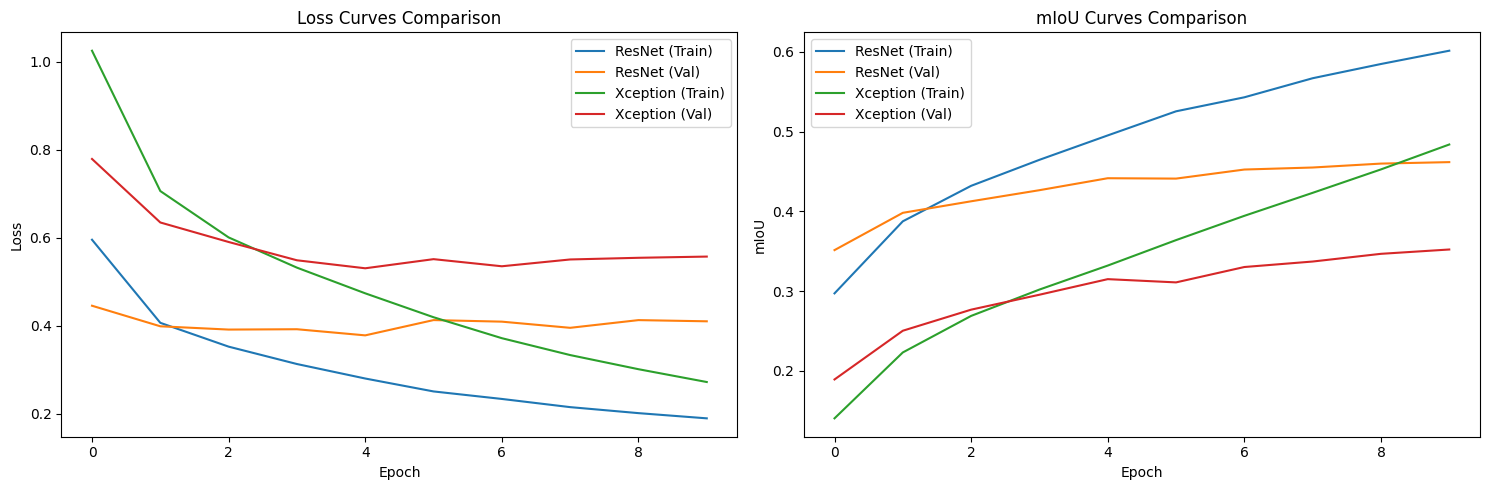

In [32]:
# 결과 비교 시각화
plt.figure(figsize=(15, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(history_resnet['train_loss'], label='ResNet (Train)')
plt.plot(history_resnet['val_loss'], label='ResNet (Val)')
plt.plot(history_xception['train_loss'], label='Xception (Train)')
plt.plot(history_xception['val_loss'], label='Xception (Val)')
plt.title('Loss Curves Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# mIoU comparison
plt.subplot(1, 2, 2)
plt.plot(history_resnet['train_miou'], label='ResNet (Train)')
plt.plot(history_resnet['val_miou'], label='ResNet (Val)')
plt.plot(history_xception['train_miou'], label='Xception (Train)')
plt.plot(history_xception['val_miou'], label='Xception (Val)')
plt.title('mIoU Curves Comparison')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Colormap 로드
colormap = scipy.io.loadmat(colormap_path)['colormap']
colormap = (colormap * 255).astype(np.uint8)


Visualizing ResNet backbone results...


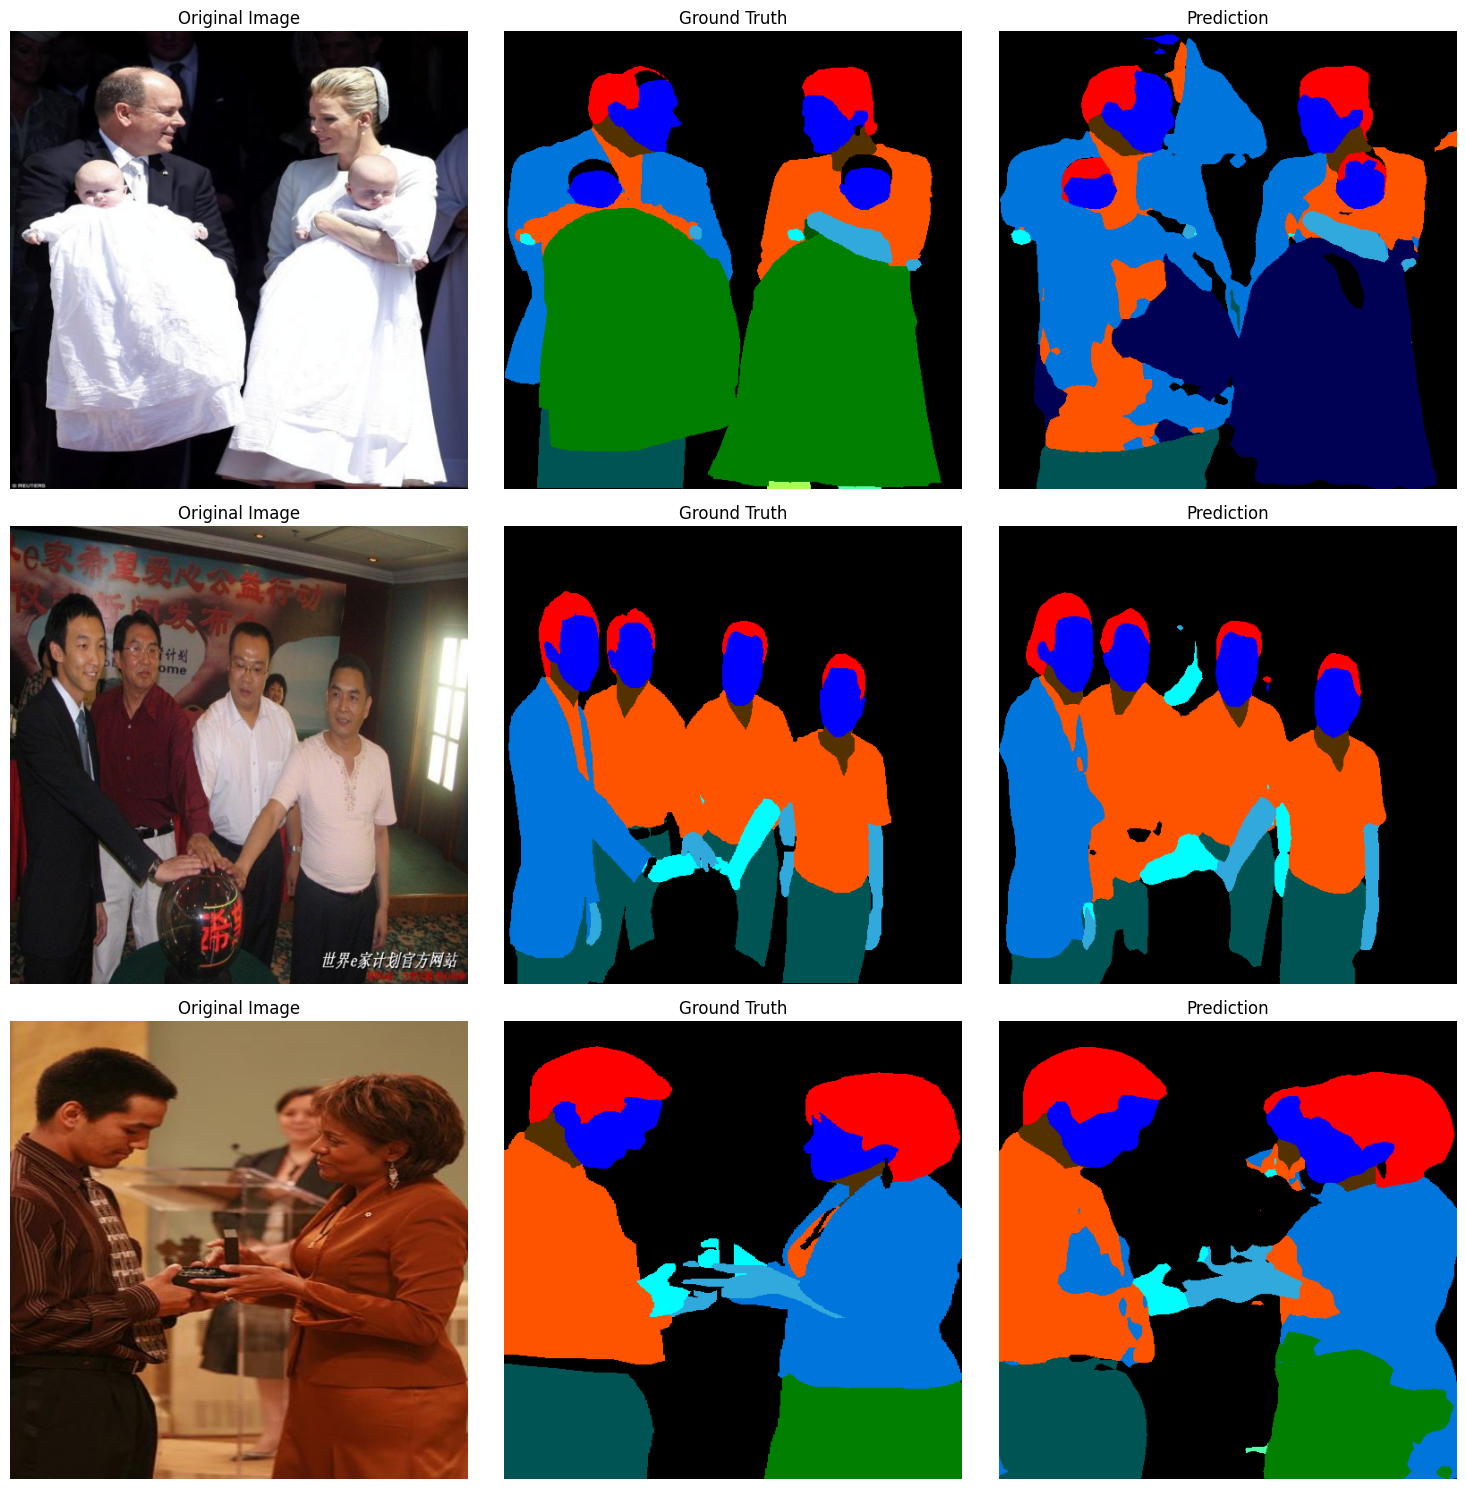

In [34]:
# 세그멘테이션 결과 시각화 (ResNet)
print("\nVisualizing ResNet backbone results...")
visualize_results(model_resnet, val_dataset, device, colormap, num_samples=3)


Visualizing Xception backbone results...


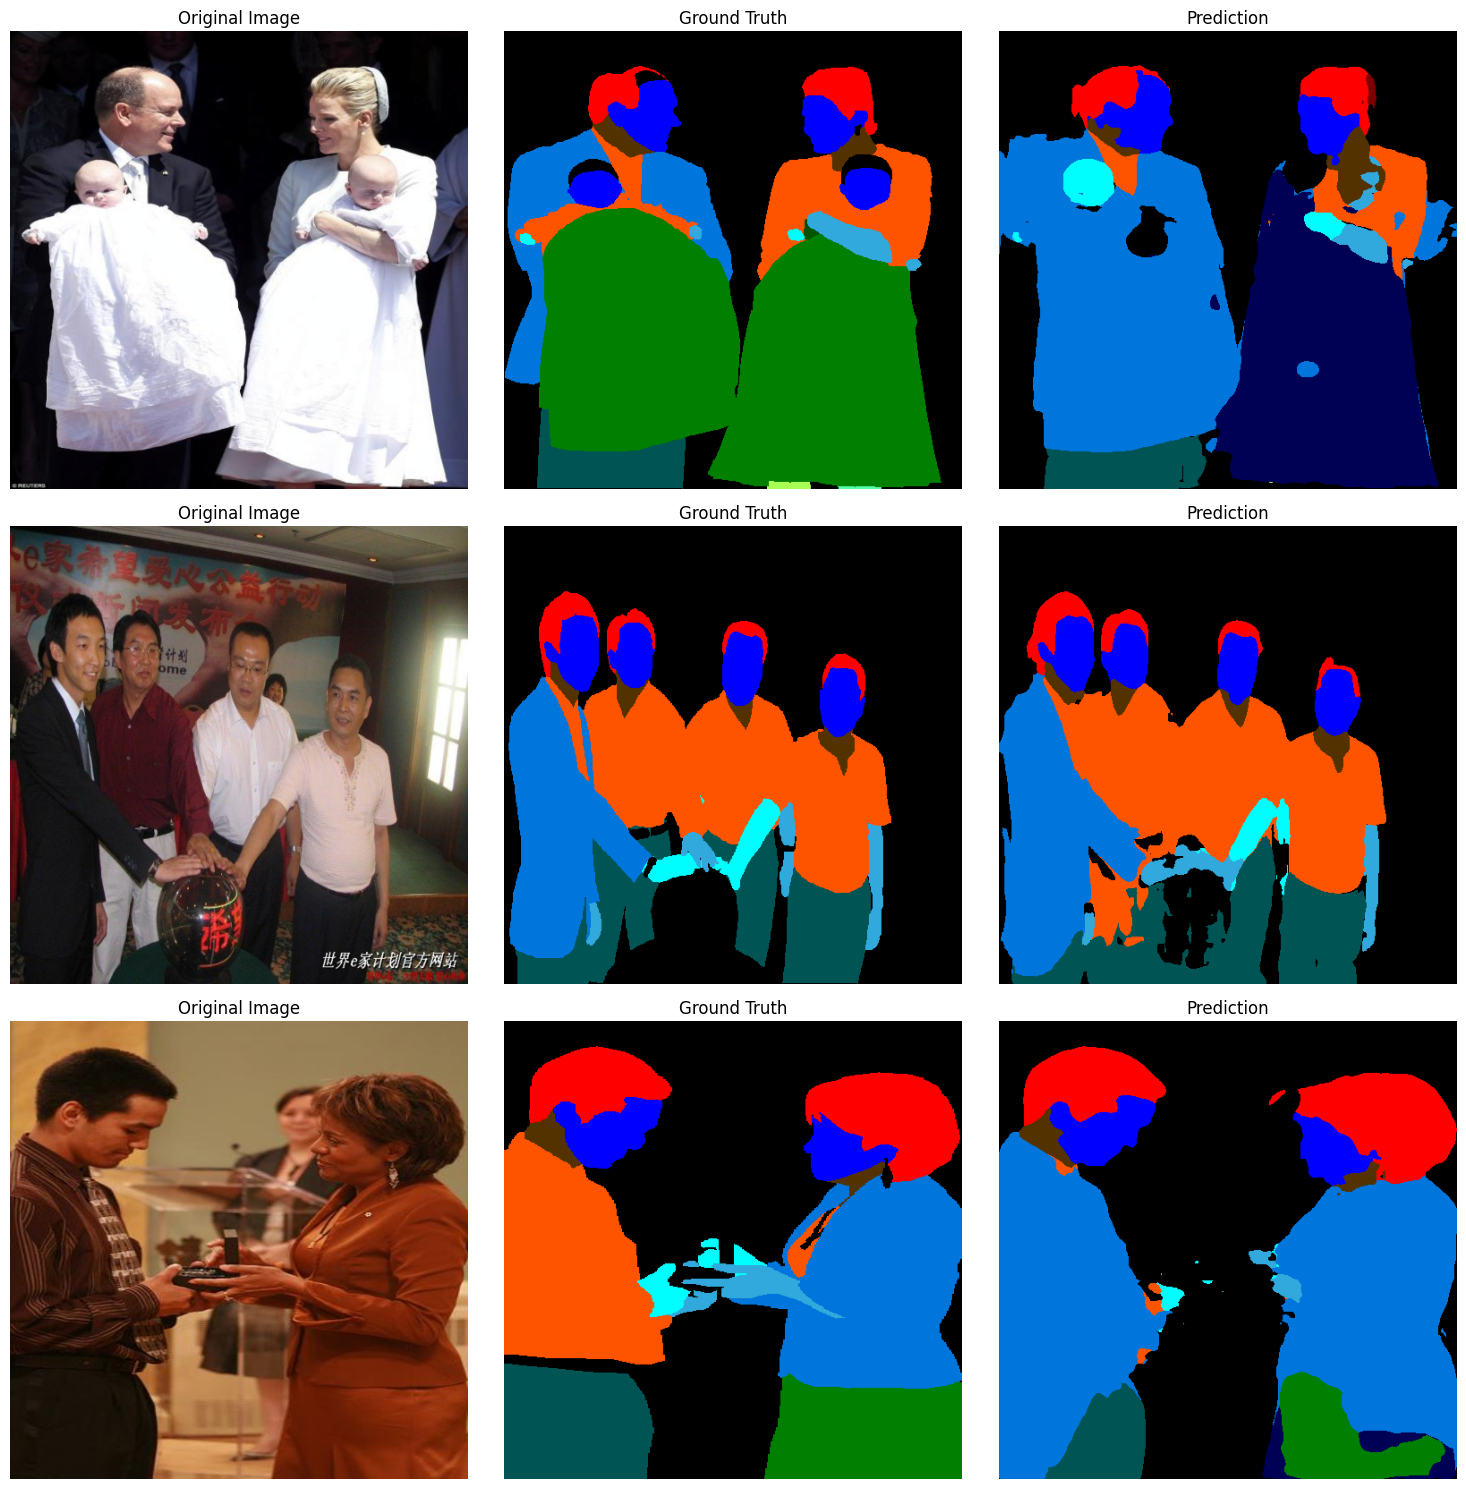


Training and evaluation completed!


In [35]:

# 세그멘테이션 결과 시각화 (Xception)
print("\nVisualizing Xception backbone results...")
visualize_results(model_xception, val_dataset, device, colormap, num_samples=3)

print("\nTraining and evaluation completed!")